# Exercise for OR-INF transport module 2021
Introduction to the basics of transport modelling. If you want to learn more by yourself, have a read in [Modelling Transport by Ortúzar and Willumsen](https://www.wiley.com/en-us/Modelling+Transport%2C+4th+Edition-p-9780470760390) or have a look into a more complex [transport model for Germany](https://github.com/marlinarnz/quetzal_germany).

In [1]:
# Libraries we need
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import geometry
from geopy.distance import geodesic

The `pandas` and `numpy` libraries are core tools for all kinds of data handling and analysis in Python. `pandas` allows easy and quick handling of data in so-called DataFrames ([pandas tutorials](https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/index.html)). `geopandas` is an extension of `pandas` which adds functionalities for geometric operations. `numpy` is the essential library for mathematical operations. `shapely.geometry` provides classes for geometric operations, while `geopy.distance.geodesic` provides a method for calculation geometric distances in meters.

## Create a test network
Before we get startet we need nodes and links to carry out transport analysis.

In [2]:
# Create our test network nodes
nodes = pd.DataFrame(
    data={'name': ['Berlin', 'Hamburg', 'Frankfurt', 'Stuttgart'],
          'lat': [52.518611, 53.550556, 50.110556, 48.775556],
          'lon': [13.408333, 9.993333, 8.682222, 9.182778]})
nodes

,name,lat,lon
0,Berlin,52.518611,13.408333
1,Hamburg,53.550556,9.993333
2,Frankfurt,50.110556,8.682222
3,Stuttgart,48.775556,9.182778


In [3]:
# Create a GeoDataFrame. It looks similar
# but has additional attributes like plotting
nodes = gpd.GeoDataFrame(
    nodes, geometry=gpd.points_from_xy(nodes.lon, nodes.lat))

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

<AxesSubplot:>

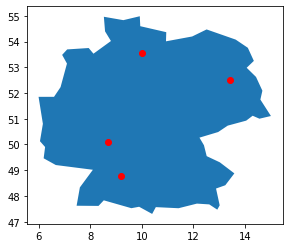

In [4]:
# Load basemap shapes
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ger = countries[countries['name']=='Germany']
# Plot test network nodes
nodes.plot(c='r', ax=ger.plot())

In [5]:
# Create links from every node to every node
links = pd.DataFrame(
    {'a': [0,0,0,1,1,1,2,2,2,3,3,3]*2,
     'b': [1,2,3,0,2,3,0,1,3,0,1,2]*2,
     'mode': ['rail']*12+['car']*12})
# Add the geometry
links = gpd.GeoDataFrame(
    links, geometry=[geometry.LineString([
        nodes.loc[row.a, 'geometry'],nodes.loc[row.b, 'geometry']
    ]) for _, row in links.iterrows()])
# Add the distance in km
links['dist'] = [geodesic(l.coords[0], l.coords[-1]).km
                 for l in list(links['geometry'])]
# Add level of service (LoS) attribute time in h
links['time'] = links['dist'] / 110 #km/h is about average
# Adjust time of rail services
links.loc[links['mode']=='rail', 'time'] = [
    1.8,4.2,6.2, 1.8,3.5,5.5, 4.2,3.5,1.5, 6.2,5.5,1.5]

In [6]:
links.head(4)

,a,b,mode,geometry,dist,time
0,0,1,rail,"LINESTRING (13.40833 52.51861, 9.99333 53.55056)",394.159512,1.8
1,0,2,rail,"LINESTRING (13.40833 52.51861, 8.68222 50.11056)",585.230160,4.2
2,0,3,rail,"LINESTRING (13.40833 52.51861, 9.18278 48.77556)",620.801595,6.2
3,1,0,rail,"LINESTRING (9.99333 53.55056, 13.40833 52.51861)",394.159512,1.8


<AxesSubplot:>

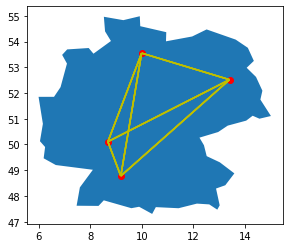

In [7]:
# Plot
nodes.plot(c='r', ax=links.plot(color='y', ax=ger.plot()))

## Step 1: Calculate mode choice probabilities
Now we can calculate the probabilities of using one or the other mode in a logit formulation. First, we use the level of service (LoS) attribute time.

In [8]:
# Mathematical formulation of the MNL model
def mnl(od_pair, los_cols=['time'], beta=[1.5]):
    '''Calculates the probabilities for each mode on the given
        OD pair
    @param od_pair: pandas DataFrame slice of links from one 
        origin to one destination for all modes of analysis
    @param los_cols: list of DataFrame column names for all LoS
        attributes of analysis
    @param beta: list of numerical calibration factors for 
        every LoS attribute given
    @return: list of probabilities for each mode in od_pair
        in order of appearence'''
    v = [sum([row[los_cols[i]] * beta[i]
              for i in range(len(los_cols))]
            ) for _, row in od_pair.iterrows()]
    p = [1 - np.exp(val) / sum([np.exp(m) for m in v])
         for val in v]
    return p

Use the above function to calculate a new column `probs_1` in links. Hint: Iterate over OD-pairs, give them to the MNL function and save the returned values to the new column of this OD pair

In [9]:
# There are many ways to get probabilities as a new col
links['probs_1'] = 

In [10]:
# Calculate the mean of the results
links.groupby('mode').agg({'probs_1': 'mean'})

,probs_1
mode,
car,0.435031
rail,0.564969


## Step 2: New LoS attribute travel cost
After adding a new column for travel cost, you can apply the above formula again. First, add a column `cost` to links. Cost in EUR have the following dependencies with trip distance:

- car (average direct cost in Germany without vehicle maintenance or purchase cost): 0.12 * distance
- rail (ticket prices without Bahncard or Sparpreis): 0.7 * distance^0.8

Hint: Use `np.power(base, exponent)` for calculation of rail fares

In [11]:
links['cost'] = 

In [12]:
links['probs_2'] = 

In [13]:
# Calculate the mean of all results


,probs_1,probs_2
mode,,
car,0.435031,0.738596
rail,0.564969,0.261404


## Step 3: Political action for sustainable transport
Now assume: Due to tax reductions for rail operators rail services cost 10% less. Moreover, a speed limit of 120km/h on motorways is enforced, which reduces average car travel speed to 100km/h. What are the new mode choice probabilities?

In [16]:
links['probs_3'] = 

In [17]:
# Calculate the mean of all results


,probs_1,probs_2,probs_3
mode,,,
car,0.435031,0.738596,0.281229
rail,0.564969,0.261404,0.718771


## Step 4: Trip volumes
Given an OD-matrix, you can calculate trip columes on each link. How many people are travelling where using which mode?

What is the summed up travel time?

In [18]:
# Number of trips per year
od_matrix = pd.read_csv('od_matrix.csv', header=None)
od_matrix.columns = ['a', 'b', 'volumes']
od_matrix.set_index(['a', 'b'], inplace=True)

In [19]:
od_matrix

volumes
a         b                 
Hamburg   Frankfurt   483000
          Stuttgart   155000
          Berlin     3396000
Frankfurt Hamburg     483000
          Stuttgart   567000
          Berlin      732000
Stuttgart Hamburg     155000
          Frankfurt   567000
          Berlin      236000
Berlin    Hamburg    3396000
          Frankfurt   732000
          Stuttgart   236000

In [20]:
# Calculate trip volumes and print averages


In [21]:
links.head()

,a,b,mode,geometry,dist,time,probs_1,cost,probs_2,probs_3,volumes
0,0,1,rail,"LINESTRING (13.40833 52.51861, 9.99333 53.55056)",394.159512,1.8,0.935529,42.569227,0.703777,0.969198,3.291396e+06
1,0,2,rail,"LINESTRING (13.40833 52.51861, 8.68222 50.11056)",585.230160,4.2,0.842959,63.204857,0.369296,0.944254,6.911940e+05
2,0,3,rail,"LINESTRING (13.40833 52.51861, 9.18278 48.77556)",620.801595,6.2,0.302689,67.046572,0.042551,0.594959,1.404104e+05
3,1,0,rail,"LINESTRING (9.99333 53.55056, 13.40833 52.51861)",394.159512,1.8,0.935529,42.569227,0.703777,0.969198,3.291396e+06
4,1,2,rail,"LINESTRING (9.99333 53.55056, 8.68222 50.11056)",404.756718,3.5,0.566948,43.713725,0.172772,0.743493,3.591072e+05


In [22]:
# Calculate mode shares in passenger kilometer (pkm)
# and print/visualise them
links['pkm'] = 

,pkm
mode,
car,4.249495e+07
rail,3.375642e+08


<AxesSubplot:>

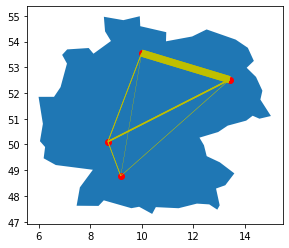

In [23]:
# Plot the volumes on the network as width of links
# for road transport
nodes.plot(c='r', ax=links.loc[links['mode']=='car'].plot(
    color='y', linewidth=[v / links['volumes'].mean()
                          for v in links['volumes']], ax=ger.plot()))

<AxesSubplot:>

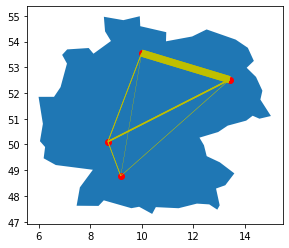

In [24]:
# Plot the volumes on the network as width of links
# for rail transport


In [25]:
# Aggregated travel time


28815620.37508989

## Step 5: Capacities and congestion
So far, travel on our test network was not restricted. However, in reality roads become congested and trains crowded. Given the capacities of links and a volume-dependent congestion formula, how do people travel now? What is the new aggregated travel time?

You need at least five iterations to reach an equilibrium between volumes and capacities.

In [ ]:
# Average occupancy in ICE trains is low in Germany while
# main motorways are quite packed
links['cap'] = [row['volumes']*1.25
                if row['mode']=='car' else row['volumes']*3
                for _, row in links.iterrows()]

In [ ]:
def travel_time(volumes, capacity, time):
    '''Calculates the travel time of a link with capacity
    restriction applying the formula used by Smock (1962)
    @param volumes: volume of trips on this link
    @param capacity: capacity for trips on this link
    @param time: travel time without capacity restriction
    @return: new travel time'''
    return 0.5 * time * np.exp(volumes / capacity)

In [ ]:
links['time_2'] = 

In [ ]:
links['probs_4'] = 

In [ ]:
links.sample(4)

In [ ]:
# Calculate the mean of all results


In [ ]:
# Aggregated travel time


## Step 6: Impact of lorries
Looking into the future, roads will become even more congested by lorries due to the rising demand for goods transport, if there is no political ambition for a shift to rail in freight transport. Given these new capacities, how does the mode share in passenger transport change? And the aggregated travel time?

In [ ]:
links['cap_2'] = [row['cap']*0.9
                  if row['mode']=='car' else row['cap']
                  for _, row in links.iterrows()]

# End
Congrats! You've learned the basics of open source transport modelling with Python. If you want you can go on with altering capacities, adding new nodes or modes or even adding a new LoS attribute.